In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# Data Wrangling

**Problem Statement**   

Buying a house can be a very challenging process. It takes time, patience, and a lot of research to find a house that you like and then negotiate the right price for it. There are several features that influence house price such as the building type, total number of rooms, garage size, masonary work, location, utilities, and many more. Can house price be estimated (or predicted) using these features? Can we identify features that influence house price the most? How important is Building Type in determining the price? What influences the price more: location or size (sq.ft.)? How much value does remodeling add to the house? These are a few questions among many more that I intend to explore and answer.

**Dataset**

Dataset is available on kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). It is the Ames Housing dataset, compiled by Dean De Cock. It has 1460 instances and 79 explanatory variables that describe almost every aspect of residential homes in Ames, Iowa.

In this part, we will explore the data. In the process, we will clean and augment the data with additional information from other sources. We will perform the following steps:

- Identify and remove outliers
- Fill missing values
- Augment the dataset by collecting and adding data from other sources like Google's Geocoding API and uszipcode library

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns
%matplotlib inline

sns.set(style ='white',font_scale=1.25)

# sklearn pipeline tools
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set waring to 'ignore' to prevent them from prining on screen
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset, and look at first few rows
housing_raw = pd.read_csv('data/train.csv',index_col='Id')
housing = housing_raw.copy()
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Datatype of each column
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

We can see there are a lot of numerical and categorical features.  
Lets first take look at the numerical (particularly continous) features to spot outliers.

In [5]:
# Created a list of continous features to check their distribution and spot potential outliers
cont_feats = ['SalePrice','LotFrontage',
              'LotArea','MasVnrArea',
              'BsmtFinSF1','BsmtFinSF2',
              'BsmtUnfSF','TotalBsmtSF',
              '1stFlrSF','2ndFlrSF',
              'LowQualFinSF','GrLivArea',
              'GarageArea','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch',
              'ScreenPorch']

## Distributions of Continous Features.

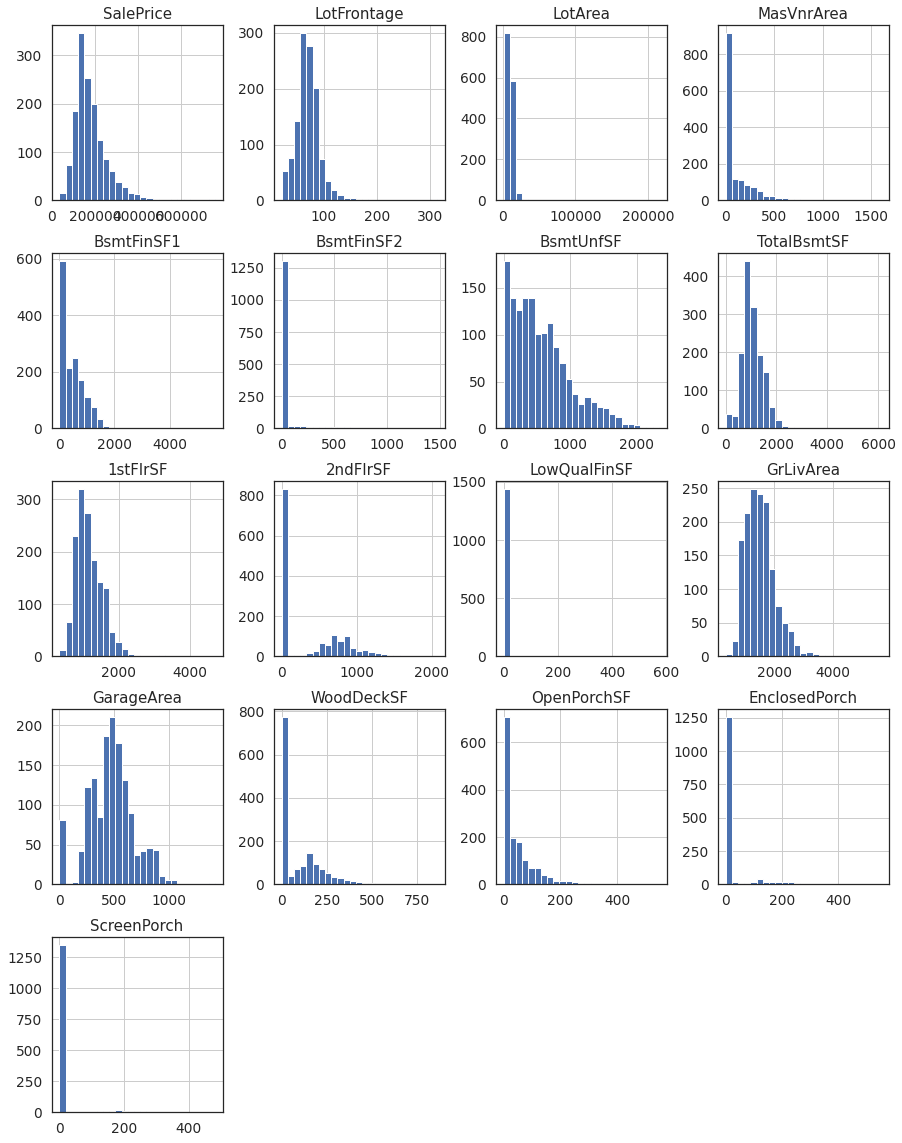

In [6]:
_=housing[cont_feats].hist(figsize = (15,20),bins=25)

## Distribution of SalePrice (target variable)

In [7]:
from scipy import stats

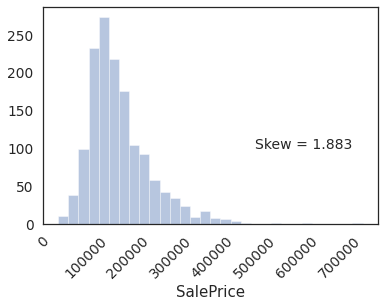

In [8]:
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has a postive skew.  Let apply a log tranform.

In [9]:
housing['log1p(SalePrice)'] = np.log1p(housing['SalePrice'])

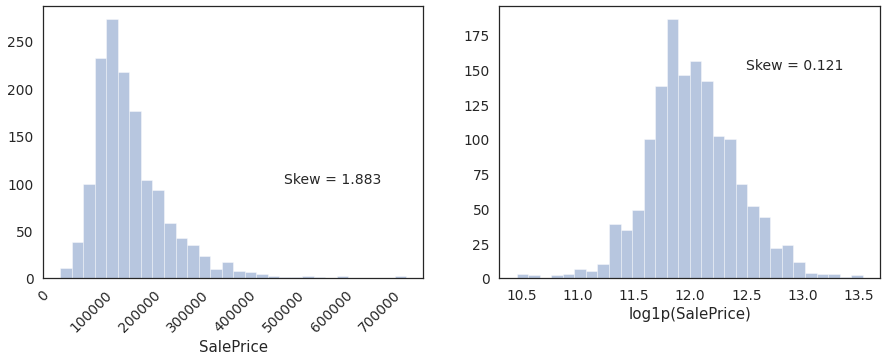

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.SalePrice, kde=False, bins=30)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing.SalePrice.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

plt.subplot(1,2,2)
sns.distplot(housing['log1p(SalePrice)'], kde=False, bins=30)
_=plt.text(x=12.5, y=150,s='Skew = %.3f' %(housing['log1p(SalePrice)'].skew()),fontdict={'fontsize':14})

Looks close to normal after tranforming.

## Outlier Identification

### Distribution of GrLivArea

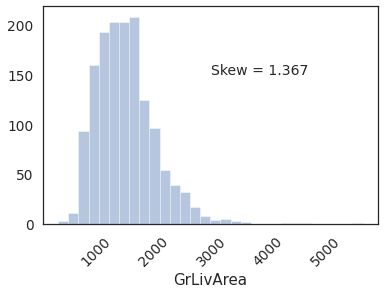

In [11]:
sns.distplot(housing.GrLivArea, kde=False, bins=30)
plt.text(x=3000, y=150,s='Skew = %.3f' %(housing.GrLivArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution has positve skew.

Lets also apply log tranform to GrLivArea.

In [12]:
# Initialize a transformer list object to keep track of all data preprocessing steps
transformers = []
def log1p(X,columns):
    X_new = X.copy()
    for col in columns:
        X_new['log1p({})'.format(col)] = np.log1p(X_new[col])
        #X_new.drop(col,axis=1,inplace=True)
    return X_new

from sklearn.preprocessing import FunctionTransformer
log_trans = FunctionTransformer(log1p,validate=False,
                                      kw_args=dict(columns=['GrLivArea']))
transformers.append(('log_trans',log_trans))

In [13]:
housing['log1p(GrLivArea)'] = np.log1p(housing.GrLivArea)

Text(0, 0.5, 'log1p(SalePrice)')

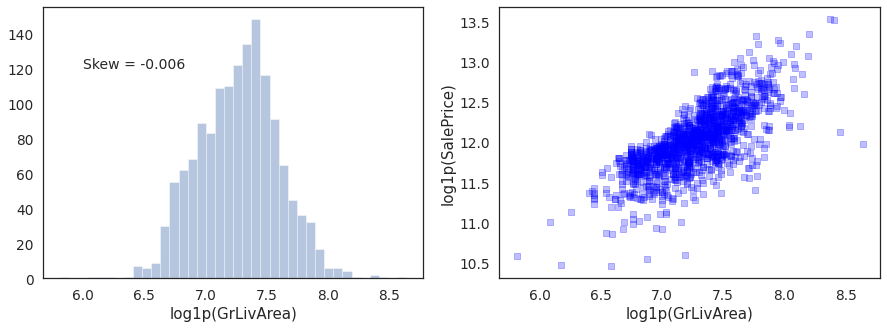

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing['log1p(GrLivArea)'],kde=False,bins=int(np.sqrt(len(housing))))
plt.text(x=6, y=120,s='Skew = %.3f' %(housing['log1p(GrLivArea)'].skew()),fontdict={'fontsize':14})
plt.subplot(1,2,2)
plt.scatter(housing['log1p(GrLivArea)'], housing['log1p(SalePrice)'], c='blue',marker = 's',alpha=0.25)
plt.xlabel('log1p(GrLivArea)')
plt.ylabel('log1p(SalePrice)')

No apparent outliers in log of GrLivArea. Distrubution also looks normal.

### Distribution of GarageArea

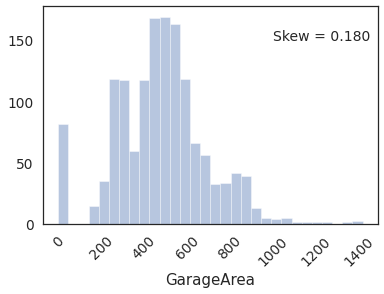

In [15]:
sns.distplot(housing.GarageArea, kde=False, bins=30)
plt.text(x=1000, y=150,s='Skew = %.3f' %(housing.GarageArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distibution looks reasonably normal.

Text(0, 0.5, 'SalePrice')

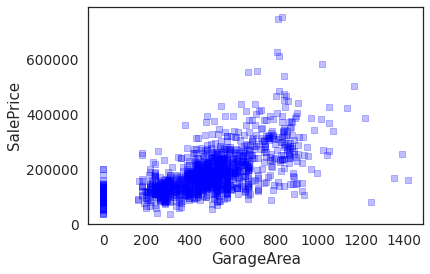

In [16]:
plt.scatter(housing.GarageArea, 
            housing.SalePrice, c='blue',marker = 's',alpha=0.25)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

No apparent outliers in the scatter plot

### Distribution LotArea

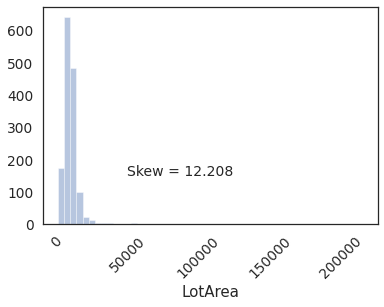

In [17]:
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)

Distribution is highly skewed due to outliers.

Text(0, 0.5, 'log1p(SalePrice)')

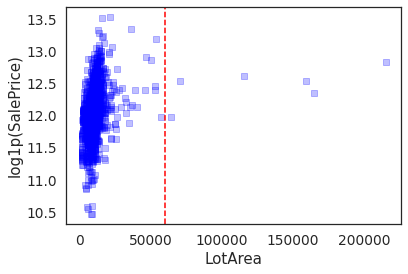

In [18]:
plt.scatter(housing.LotArea, 
            housing['log1p(SalePrice)'], c='blue',marker = 's',alpha=0.25)
plt.axvline(x=60000,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('log1p(SalePrice)')

LotArea > 60000 seem like outliers. Lets remove them.

Text(0.5, 1.0, 'After removing Lot Area > 60000 sq.ft.')

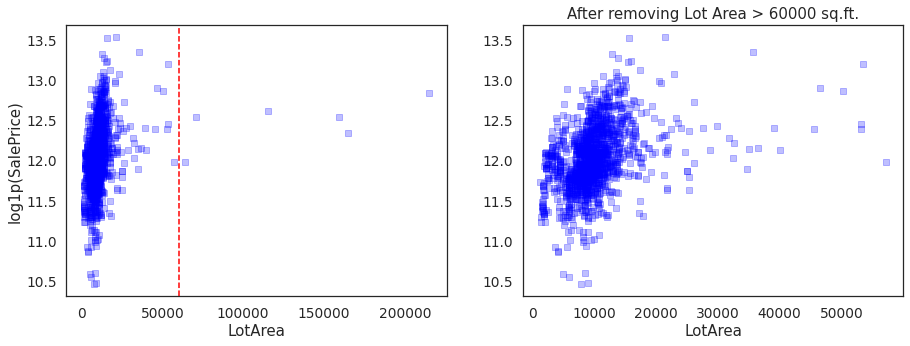

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(housing.LotArea, 
            housing['log1p(SalePrice)'], 
            c='blue',marker = 's',alpha=0.25)
plt.axvline(x=60000,color='red',linestyle='--')
plt.xlabel('LotArea')
plt.ylabel('log1p(SalePrice)')

outlier = pd.DataFrame()
outlier['LotArea'] = housing.LotArea > 60000

plt.subplot(1,2,2)
plt.scatter(housing[~outlier.any(axis=1)].LotArea, housing[~outlier.any(axis=1)]['log1p(SalePrice)'], c='blue',marker = 's',alpha=0.25)
plt.xlabel('LotArea')
plt.ylabel('')
plt.title('After removing Lot Area > %.0f sq.ft.' %(60000))

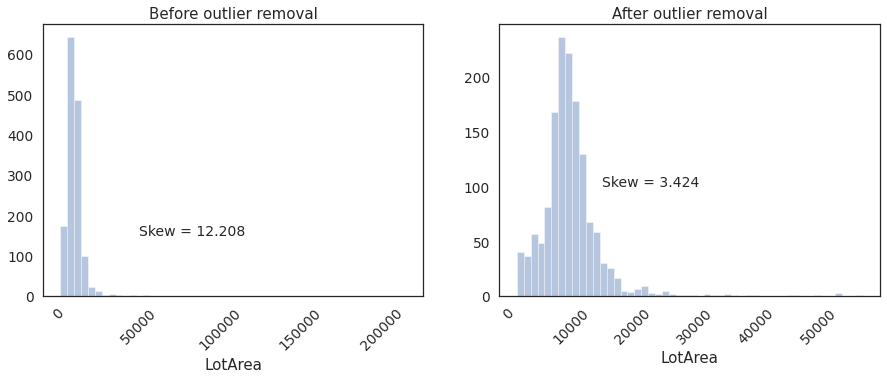

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(housing.LotArea, kde=False, bins=50)
plt.text(x=50000, y=150,s='Skew = %.3f' %(housing.LotArea.skew()),fontdict={'fontsize':14})
_=plt.xticks(rotation = 45)
_=plt.title('Before outlier removal')

plt.subplot(1,2,2)
sns.distplot(housing[~outlier.any(axis=1)]['LotArea'], kde=False, bins=50)
plt.text(x=15000, y=100,s='Skew = %.3f' %(housing[~outlier.any(axis=1)]['LotArea'].skew()),fontdict={'fontsize':14})
_=plt.title('After outlier removal')
_=plt.xticks(rotation = 45)

Skeweness improved considerably after removing outliers. Distribution has looks reasonably normal.

In [21]:
print('Number of examples before outlier removal: ',housing.shape[0])
print('Number of examples after outlier removal: ',housing[~outlier.any(axis=1)].shape[0])
print('%i examples are excluded' %(housing.shape[0]-housing[~outlier.any(axis=1)].shape[0]))

Number of examples before outlier removal:  1460
Number of examples after outlier removal:  1454
6 examples are excluded


In [22]:
def remove_outliers(X,columns,thresholds):
    outlier = pd.DataFrame()
    for column,threshold in zip(columns,thresholds):
        if column == 'GrLivArea':
            outlier[column] = X[column] > threshold
        elif column == 'LotArea':
            percentile = np.percentile(X[column],99)
            outlier[column] = X[column] > threshold
        else:
            print(column+' not processed for outliers')
    return X[~outlier.any(axis=1)]

outlier_remover = FunctionTransformer(remove_outliers,validate=False,
                                      kw_args=dict(columns=['LotArea'],
                                                   thresholds=[60000]))
outlier_remover.fit(housing) # Fit on training data

transformers.append(('outlier_remover',outlier_remover))

housing = outlier_remover.transform(housing) ## Use this line instead the next cell

In [23]:
#housing = housing[~outlier.any(axis=1)]
print('Dataset size:',housing.shape)

Dataset size: (1454, 82)


For more advanced methods of dealing with outliers, ref to:  
    1. https://pyod.readthedocs.io/en/latest/  
    2. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In the next step we will treat missing values.

## Missing Value Treatment

### Categorical Features
Lets first treat missing values in the categorical features  

**MSSubclass** is a categorical feature but it got loaded as a numerical feature, so lets change it to categorical.

In [24]:
def to_str(X,columns):
    for column in columns:
        X[column] = X[column].astype(str)
    return X

to_string = FunctionTransformer(to_str,validate=False,
                                      kw_args=dict(columns=["MSSubClass"]))
to_string.fit(housing) # fit on training data
transformers.append(('MSSubClass_to_str',to_string))
housing = to_string.transform(housing)

In [25]:
from collections import defaultdict

# Initialize a feature dictionary which will keep track of all features
FEATURES = defaultdict(list)

In [26]:
missing_vals_cat = pd.DataFrame(columns=['Feature', '# of missing vals','% of missing vals'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes == 'object':
        FEATURES['cat'].append(feature)
        if numNan != 0:
            missing_vals_cat = pd.concat([missing_vals_cat,pd.DataFrame([feature,numNan,(numNan/housing.shape[0])*100],
                                                                        index=['Feature', '# of missing vals','% of missing vals']).T])
            
missing_vals_cat.sort_values(by=['% of missing vals'],ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,PoolQC,1448,99.5873
1,MiscFeature,1402,96.4237
2,Alley,1363,93.7414
3,Fence,1173,80.674
4,FireplaceQu,690,47.4553
5,GarageType,81,5.57084
6,GarageFinish,81,5.57084
7,GarageQual,81,5.57084
8,GarageCond,81,5.57084
9,BsmtExposure,38,2.61348


There are two categorical features, **Electrical** and **MasVnrType**, that have missing values. Both have insignificant amounts of missing values (0.072% and 0.51%), hence it will be reasonable to impute them with the most frequently occuring category.

All other features have "meaningful" missing values. For example, if a house does not have a basement, all features related basement are going to be null values. Hence, replace those missing values in another category called "**Missing**".

#### Electrical & MasVnrType

Text(0.5, 1.0, 'MasVnrType')

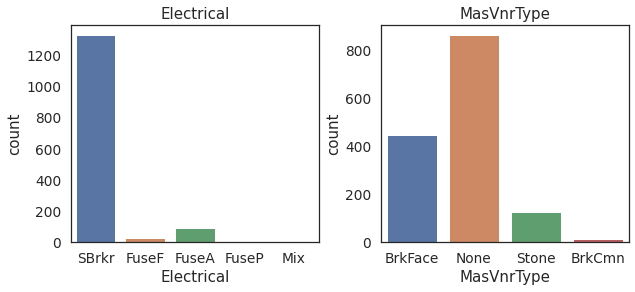

In [27]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
fig.subplots_adjust(wspace=0.25)
sns.countplot(x='Electrical',data=housing,ax=ax1)
ax1.set_title('Electrical')
sns.countplot(x='MasVnrType',data=housing,ax=ax2)
ax2.set_title('MasVnrType')

***SBrkr*** is the most frequent category in the **Electrical**.

***None*** is the most frequent category in **MasVnrType**.

Impute the missing categories with most frequently occuring ones.

In [28]:
cat_mode_mapper = housing[FEATURES['cat']].mode().iloc[0].to_dict()

def impute_cat(X,feat_to_mode=['Electrical','MasVnrType'], mapper = cat_mode_mapper):
    """
    Imputes missing values in Electrical and MasVnrType with modes, 
    and replaces NaN values in all other categorical features with 'Missing'
    """
    for col, mode in mapper.items():
        if col in feat_to_mode:
            X[col].fillna(mode,inplace=True)
        else:
            X[col].fillna('Missing',inplace=True)
    return X

cat_Imputer = FunctionTransformer(impute_cat,validate=False,
                                      kw_args=dict(feat_to_mode=['Electrical','MasVnrType'],
                                                   mapper=cat_mode_mapper))
cat_Imputer.fit(housing)
transformers.append(('cat_Imputer',cat_Imputer))
housing = cat_Imputer.transform(housing)

In [29]:
# Check if there are missing values in the categorical features any more
housing[FEATURES['cat']].isnull().sum()

MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

### Numerical Features

In [30]:
missing_vals_num = pd.DataFrame(columns=['Feature','# of missing values','% of missing values'])
for feature, numNan in housing.isnull().sum().iteritems():
    if housing[feature].dtypes!= 'object' and 'SalePrice' not in feature:
        FEATURES['num'].append(feature)
        if numNan != 0:
            missing_vals_num = pd.concat([missing_vals_num,
                                          pd.DataFrame([feature,numNan,
                                                        (numNan/housing.shape[0])*100],
                                                       index=['Feature','# of missing values','% of missing values']).T])

missing_vals_num.reset_index(drop = True).sort_values(by='# of missing values',ascending=False)

,Feature,# of missing values,% of missing values
0,LotFrontage,256,17.6066
2,GarageYrBlt,81,5.57084
1,MasVnrArea,8,0.550206


#### MasVnrArea
**MasVnrArea**: Since the most common category (None) was imputed for the missing values in the cat feature, **MasVnrType**, it will make sense to impute missing values in **MasVnrArea** with median **MasVnrArea** value of houses that have "None" as the **MasVnrType**.

In [31]:
MedianMasVnrArea = housing[housing['MasVnrType'] == 'None']['MasVnrArea'].median()
print("Median MasVnrArea: ",MedianMasVnrArea)

Median MasVnrArea:  0.0


#### GarageYrBlt
**GarageYrBlt**: these are same rows which have missing values in other garage related features, indicating that these houses do not have a garage. Imputing median value is a safe option, as these houses have already been flagged as missing a garage in the categorical features.

In [32]:
MedianGarageYrBlt = housing['GarageYrBlt'].median()
print("Median GarageYrBlt: ",MedianGarageYrBlt)

Median GarageYrBlt:  1980.0


#### LotForntage
**LotForntage**: missing values needs to be handled more carefully as they amount to 17.73% of the total oberservation.

   - Let's take a look at the other three features associated with Lot: LotConfig, LotShape, and LotArea

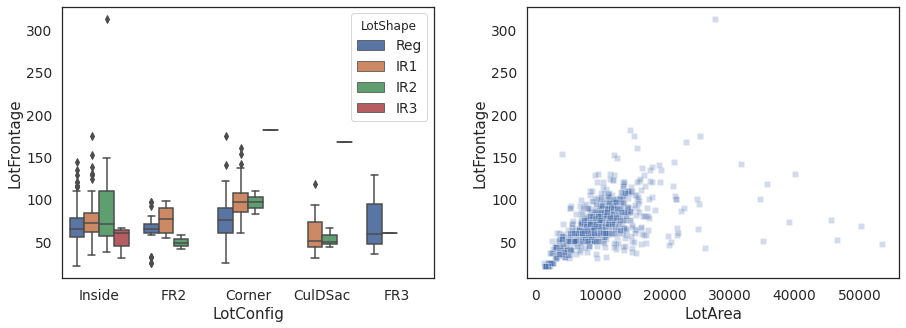

In [33]:
plt.figure(figsize = (15,5))
plt.subplots_adjust(wspace=0.25)
plt.subplot(1,2,1)
sns.boxplot(x='LotConfig',y='LotFrontage',data=housing,hue='LotShape')
plt.subplot(1,2,2)
sns.scatterplot(x='LotArea',y='LotFrontage',data=housing,marker='s',alpha=0.25)

   - Group the data by **LotShape** and **LotConfig** and compute group specific median **LotFrontage**. 
   - Impute missing **LotFrontage** with group specific median LotFrontage values.

In [34]:
num_median_mapper = housing[FEATURES['num']].median().to_dict()
num_median_mapper['LotFrontage'] = housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()

def impute_num(X,mapper=num_median_mapper):
    for feat,vals in mapper.items():
        if feat == 'LotFrontage':
            for key,val in vals.items():
                LotConfig,LotShape = key
                X.loc[(X['LotFrontage'].isnull()) & (X['LotConfig']==LotConfig) & (X['LotShape']==LotShape),['LotFrontage']] = val
            X.loc[X['LotFrontage'].isnull(),'LotFrontage'] = X['LotFrontage'].median()
        else:
            X[feat].fillna(vals,inplace=True)
    return X

num_imputer = FunctionTransformer(impute_num,validate=False,
                                      kw_args=dict(mapper=num_median_mapper))
num_imputer.fit(housing)

transformers.append(('num_imputer',num_imputer))

housing = num_imputer.transform(housing)

In [35]:
# Check if there are any missing values in the entire dataset anymore.
housing.isnull().sum().sum()

0

**Data cleaning is done at this point.**

Next, we will add more data to the dataset from other sources.

## Data Augmentation
In this part, we will add more features to the dataset by gathering data from other sources like **Google's Geocoding API** and **uszipcode** library. 

In [36]:
# Number of unique categories per categorical feature
unique_cats = defaultdict(int)

for col in housing.columns:
    if housing[col].dtypes == 'object':
        unique_cats[col] = housing[col].nunique()
        #print('{0}:\t\t {1} unique categories'.format(col,housing_cat[col].nunique()))

num_unique_cats = pd.Series(unique_cats)
num_unique_cats.sort_values(ascending = False)

Neighborhood     25
Exterior2nd      16
MSSubClass       15
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          7
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
ExterCond         5
Electrical        5
BsmtQual          5
BsmtCond          5
BsmtExposure      5
MasVnrType        4
LotShape          4
ExterQual         4
KitchenQual       4
PoolQC            4
GarageFinish      4
LandContour       4
Alley             3
LandSlope         3
PavedDrive        3
Utilities         2
Street            2
CentralAir        2
dtype: int64

Neighborhood has most number of unique categories. The categories are some sort of location names.  

### Google API: Geocoding

In this section, we will extract Latitude and Longitude coordinates, and zipcodes from Google's Geocoding API.

In [37]:
import googlemaps
import json
# Import the googlemaps API key
with open('data/keys.json') as file:
    keys = json.load(file)
    
gmaps = googlemaps.Client(key=keys['geocoding'])

In [38]:
# List of neighborhoods
housing.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [39]:
neighborhoods = {"CollgCr":"College Creek","Veenker":"Veenker",
                 "Crawfor":"Crawford","NoRidge":"Northridge",
                 "Mitchel":"Mitchell","Somerst":"Somerset",
                 "NWAmes":"Northwest Ames","OldTown":"Old Town",
                 "BrkSide":"Brookside","Sawyer":"Sawyer",
                 "NridgHt":"Northridge Heights","NAmes":"North Ames",
                 "SawyerW":"Sawyer West","IDOTRR":"Iowa DOT and Rail Road",
                 "MeadowV":"Meadow Village","Edwards":"Edwards",
                 "Timber":"Timberland","Gilbert":"Gilbert",
                 "StoneBr":"Stone Brook","ClearCr":"Clear Creek",
                 "NPkVill":"Northpark Villa","Blmngtn":"Bloomington Heights",
                 "BrDale":"Briardale","SWISU":"South & West of Iowa State University",
                 "Blueste":"Bluestem"}

Let's create a separate dataframe with unique Neighborhood categories

In [40]:
geo_df = pd.DataFrame(housing.Neighborhood.unique(),columns=['Neighborhood'])
geo_df.head()

,Neighborhood
0,CollgCr
1,Veenker
2,Crawfor
3,NoRidge
4,Mitchel


In [41]:
import re
def getGeoInfo(Neighborhood, output):
    '''
     Enter the Neighborhood and the kind of output you want (lat,lng, or zipcode)
    '''
    def getZipCode(formatted_address):
        substr = re.findall('IA \d{5}, USA',formatted_address)
        if len(substr) == 0:
            return 'Missing'
        else:
            return re.findall('\d{5}',substr[0])[0]

    geocode_result = gmaps.geocode(neighborhoods[Neighborhood]+', Ames, IA')
    
    i = 0
    while True:
        if i == len(geocode_result):
            idx = None
            break
        elif 'IA' in geocode_result[i]['formatted_address']:
            idx = i
            break
        i += 1
        
    lat = geocode_result[idx]['geometry']['location']['lat']
    lng = geocode_result[idx]['geometry']['location']['lng']
    zipcode = getZipCode(geocode_result[idx]['formatted_address'])

    if output == 'lat':
        return lat
    elif output == 'lng':
        return lng
    elif output == 'zipcode':
        return zipcode
    else:
        return 'invalid output!'

In [42]:
geo_df['Lat'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lat')
geo_df['Lng'] = geo_df['Neighborhood'].apply(getGeoInfo,output='lng')
geo_df['zipcode'] = geo_df['Neighborhood'].apply(getGeoInfo,output='zipcode')

In [43]:
geo_df

,Neighborhood,Lat,Lng,zipcode
0,CollgCr,42.022197,-93.651510,Missing
1,Veenker,42.041304,-93.650302,50011
2,Crawfor,42.018614,-93.648898,50014
3,NoRidge,42.047831,-93.646745,50010
4,Mitchel,41.990308,-93.601053,50010
5,Somerst,42.052628,-93.644582,50010
6,NWAmes,42.038277,-93.625770,50010
7,OldTown,42.029046,-93.614340,50010
8,BrkSide,42.028653,-93.630386,50010
9,Sawyer,42.033903,-93.677066,50014


In geo_df, there are two Neighborhoods (CollgCr, NPkVill) for which Google's gecoding API was not able to provide the zipcode.

Lets look at Lat vs. Lng scatter plot to see which neighborhoods are close to those with missing zipcode. 

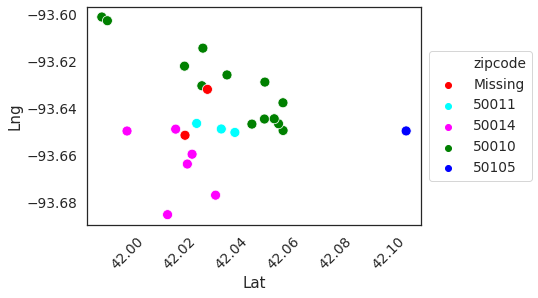

In [44]:
sns.scatterplot(x='Lat',y='Lng',
                data=geo_df,
                hue='zipcode',
                palette=['red','cyan','magenta','green','blue'],
                alpha=1,s=100)
plt.legend(loc='center right',bbox_to_anchor = (1.35,0.5))
_=plt.xticks(rotation=45)

It will be reasonable to impute missing zipcodes with the closest neighbors, but there is another library that can provide zipcode info based on geo coordinates. 

It is the **uszipcode** library https://pypi.org/project/uszipcode/

This library can be used to extract demographic information of different locations in US.

### uszipcode
In this section, we will impute the missing zipcode, as well as augment our dataset with more features like popution density, total population, median household income, total number of housing units, etc.

In [45]:
from uszipcode import SearchEngine

In [46]:
def getMoreFeat(a,b):
    '''
    Can take zipcode or [lat,lng] as inputs (a) and return requested information about location, 
    The information requested should be specifed as the second argument (b).

    Acceptable requests are:'lat', 'lng', 
                            'population', 'zipcode', 
                            'population_density','housing_units',
                            'occupied_housing_units', 'median_home_value'
                            'median_household_income'
    
    '''
    def getZipCode(a):
        geo_info = search.by_coordinates(a[0],a[1],radius=5)
        i = 0
        while True:
            if i == len(geo_info):
                idx = None
                break
            elif (geo_info[i].post_office_city == 'Ames, IA') and (geo_info[i].major_city == 'Ames') and (geo_info[i].common_city_list[0] == 'Ames'):
                idx = i
                break
            i += 1
            
        if idx == None:
            print("Coordinates don't belong to Ames, IA. NaN returned")
            return np.nan
        else:
            return geo_info[idx].to_dict()[b]
    
    def getRequest(zipcode,b):
        geo_info = search.by_zipcode(zipcode)
        return geo_info.to_dict()[b]
        
        
    search = SearchEngine(simple_zipcode=True)
    
    if b == 'zipcode': 
        return getZipCode(a)
    elif b in ['lat', 'lng', 'population', 'zipcode', 
                  'population_density','housing_units',
                  'occupied_housing_units', 'median_home_value',
                  'median_household_income']:
        return getRequest(a,b)
        

In [47]:
geo_df.loc[geo_df.zipcode=='Missing','zipcode'] = geo_df.loc[geo_df.zipcode=='Missing',['Lat','Lng']].apply(getMoreFeat,axis=1,b='zipcode')

In [48]:
geo_df['median_household_income'] = geo_df['zipcode'].apply(getMoreFeat,b='median_household_income')
geo_df['median_home_value'] = geo_df['zipcode'].apply(getMoreFeat,b='median_home_value')
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011,NaN,NaN
2,Crawfor,42.018614,-93.648898,50014,37661.0,212500.0
3,NoRidge,42.047831,-93.646745,50010,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010,48189.0,165300.0
5,Somerst,42.052628,-93.644582,50010,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014,37661.0,212500.0


There are missing values in median_household_income and median_home_value column. 

Lets impute missing values with most frequently occuring values.

In [49]:
geo_df['zipcode'] = geo_df.zipcode.astype(int)

In [50]:
geo_df.set_index('Neighborhood',inplace=True)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
geo_df = pd.DataFrame(imputer.fit_transform(geo_df),columns=geo_df.columns,index=geo_df.index)

geo_df.reset_index(inplace=True)

In [51]:
geo_df

,Neighborhood,Lat,Lng,zipcode,median_household_income,median_home_value
0,CollgCr,42.022197,-93.651510,50010.0,48189.0,165300.0
1,Veenker,42.041304,-93.650302,50011.0,48189.0,165300.0
2,Crawfor,42.018614,-93.648898,50014.0,37661.0,212500.0
3,NoRidge,42.047831,-93.646745,50010.0,48189.0,165300.0
4,Mitchel,41.990308,-93.601053,50010.0,48189.0,165300.0
5,Somerst,42.052628,-93.644582,50010.0,48189.0,165300.0
6,NWAmes,42.038277,-93.625770,50010.0,48189.0,165300.0
7,OldTown,42.029046,-93.614340,50010.0,48189.0,165300.0
8,BrkSide,42.028653,-93.630386,50010.0,48189.0,165300.0
9,Sawyer,42.033903,-93.677066,50014.0,37661.0,212500.0


In [52]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Neighborhood             25 non-null     object 
 1   Lat                      25 non-null     float64
 2   Lng                      25 non-null     float64
 3   zipcode                  25 non-null     float64
 4   median_household_income  25 non-null     float64
 5   median_home_value        25 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.3+ KB


In [53]:
##Adding new features to FEATURES dictionary
for col in geo_df:
    if col == 'Neighborhood':
        print(col+' already in FETAURES["cat"]')
    elif geo_df[col].dtypes == 'object':
        FEATURES['aug_cat'].append(col)
    else:
        FEATURES['aug_num'].append(col)

Neighborhood already in FETAURES["cat"]


Now that geo_df is ready, which includes geographical and demographical information, lets merge it with the main dataset.

In [54]:
def augment(X,geo_df):
    X.reset_index(inplace=True)
    X = X.merge(geo_df,how='left')
    X.set_index('Id',inplace=True)
    return X

augmenter = FunctionTransformer(augment,validate=False,kw_args=dict(geo_df=geo_df))
transformers.append(('augmenter',augmenter))

housing = augmenter.fit_transform(housing)
print(housing.shape)

(1454, 87)


In [55]:
test = pd.read_csv('data/test.csv',index_col='Id')
my_pipeline = Pipeline(transformers)
my_pipeline.fit(housing_raw)
housing_temp = my_pipeline.transform(housing_raw)

print('Manually and pipeline created datasets are equal:')
print(housing.drop('log1p(SalePrice)',axis=1).equals(housing_temp))

test_temp = my_pipeline.transform(test)

Manually and pipeline created datasets are equal:
True


In [56]:
# Add newly added numerical features to FEATURES dictionary
for feature in housing.columns:
    if feature not in FEATURES['cat']+FEATURES['num']+FEATURES['aug_num']:
        print(feature+' is missing in housing_temp')

SalePrice is missing in housing_temp
log1p(SalePrice) is missing in housing_temp


Correlations of the newly added geographic and demograpic features with the target variable. 

Text(0.5, 1.0, 'Correlation Matrix')

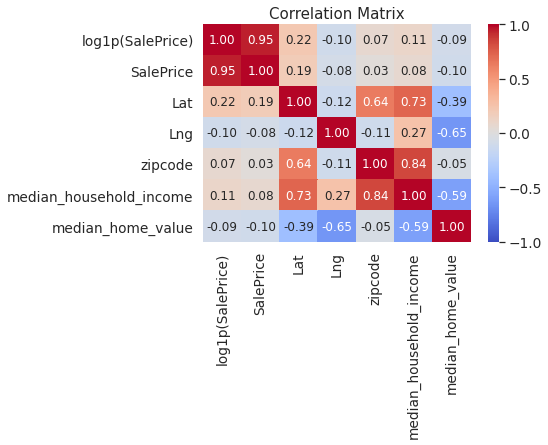

In [57]:
plt.figure(figsize=(6,4))
sns.heatmap(housing[['log1p(SalePrice)','SalePrice','Lat','Lng','zipcode','median_household_income','median_home_value']].corr(),
           vmin=-1,vmax=1,cmap='coolwarm',annot=True,annot_kws=dict(size=12),fmt='.2f')
plt.title('Correlation Matrix')

Correlations are high, but lets keep these features for now. We will come back to this later.

In [58]:
print('Dimensions of the dataset',housing[FEATURES['num']+FEATURES['cat']].shape)

Dimensions of the dataset (1454, 80)


**At this point, data is free of outliers and missing values.**

In [59]:
with open('data/wrangled_data.pkl','wb') as file:
    pickle.dump((housing,FEATURES,transformers),file)